# Multimedia Systems and Applications HW2
## Project-- Speech Processing
使用python 以 jupyter notebook撰寫

## 內容
- project2-Speech Processing.docx: 原始程式碼與大略的原始碼解說與輸出結果
- 輸出結果圖
    - 1_waveform.png
    - 2_Energy Contour.png
    - 3_Zero-Crossing Rate.png
    - 4_End Point Detection Contour.png
    - 5_Pitch Contour.png
- requirements.txt: 所需安裝套件txt檔
- main.ipynb: jupyter notebook
- main.py: jupyter notebook 輸出的py檔
- sample.wav: 錄製的音訊檔案

## 環境
|環境|名稱|版本|
|-|-|-|
|程式執行環境|jupyter notebook|1.0.0|
|python 版本|python3|3.6.9|
|安裝環境的方式|pip|20.0.2|

## 套件

```sh
pip install -r requirements.txt
```

## 程式

#### 引入套件與載入音檔
* matplot、numpy: 繪圖與數學運算
* librosa: 音訊處理的工具
* IPython: 在Jupyter notebook平台輸出聲音試驗  

載入音檔'sample.wav'

In [23]:
import wave
import matplotlib.pyplot as plt
import numpy as np
import math

import librosa
import librosa.display
import IPython.display as ipd

import scipy.signal as signal

wave, fs = librosa.load('sample.wav')

測試聲音

In [24]:
ipd.Audio('sample.wav')

#### Waveform
利用librosa內建函式顯示waveform

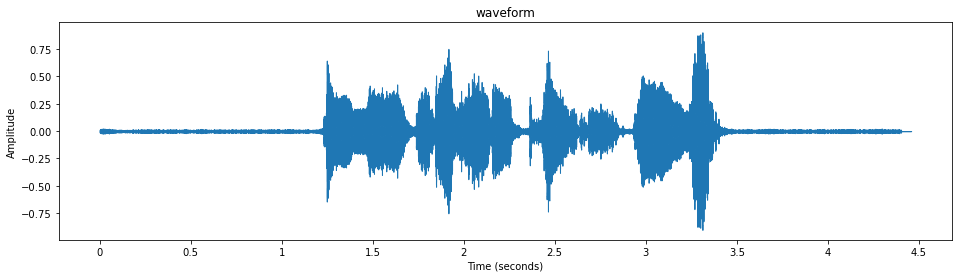

In [25]:
plt.figure(figsize=(16, 4))
librosa.display.waveshow(wave, sr=fs)
plt.title('waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

#### Energy Contour

取訊號的平方和獲得能量 
並使用librosa內建的函式計算Short-time Energy

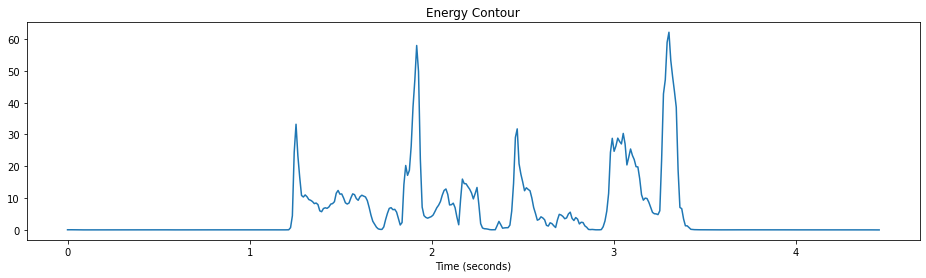

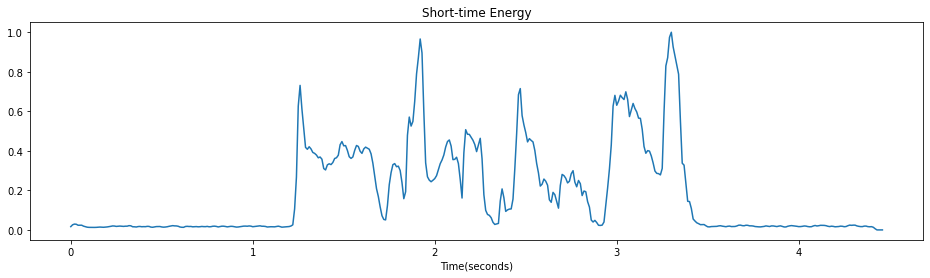

In [26]:
frame_len = int(20 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms

frames = librosa.util.frame(wave, frame_length=frame_len, hop_length=frame_shift).T
energy = np.sum(np.square(frames), axis=1)

time = np.linspace(0, len(wave)/fs, len(energy))
plt.figure(figsize=(16,4))
plt.plot(time, energy, label='Energy')
plt.title('Energy Contour')
plt.xlabel('Time (seconds)')
plt.show()

#librosa內建函式
rms = librosa.feature.rms(y=wave, frame_length=frame_len, hop_length=frame_shift)
st_energy = rms[0]
st_energy = librosa.util.normalize(st_energy, axis=0)

time = np.linspace(0, len(wave)/fs, len(st_energy))
plt.figure(figsize=(16, 4))
plt.plot(time,st_energy.T, label='Short-time Energy')
plt.title('Short-time Energy')
plt.xlabel("Time(seconds)")
plt.show()

#### Zero-Crossing Rate Contour

使用librosa內建的函式計算過零率

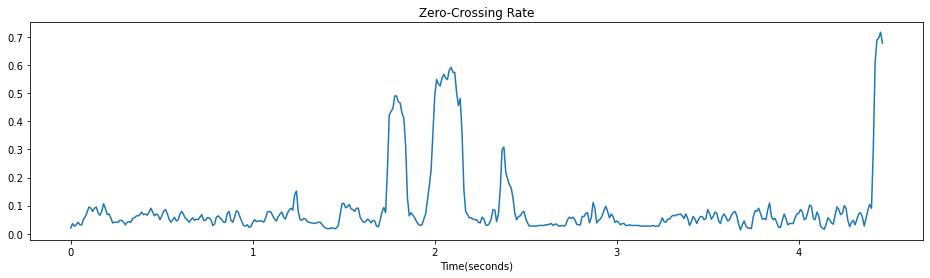

In [27]:
zcr = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zcr = zcr[0]
time = np.linspace(0, len(wave)/fs, len(zcr))

plt.figure(figsize=(16, 4))
plt.plot(time,zcr.T, label='zero-corssing rate')
plt.title('Zero-Crossing Rate')
plt.xlabel("Time(seconds)")
plt.show()

#### End Point Detection
根據計算試驗和調整的閾值預測字的起終點，並以深藍色線代表起點，紅線代表終點  
可以大致辨別出共有"多媒體系統與應用"八個字

In [28]:
def get_boundaries(rms, zrc, frame_shift, fs):
    # 找到 RMS > 0.35 或 ZRC > 0.8 的 frame indices
    frame_idxs = np.where((rms > 0.35) | (zcr > 0.8))[0]

    # 找到起始和結束的 frame indices
    start_idxs = [frame_idxs[0]]
    end_idxs = []
    for i in range(len(frame_idxs) - 1):
        if frame_idxs[i + 1] != frame_idxs[i] + 1:
            end_idxs.append(frame_idxs[i])
            start_idxs.append(frame_idxs[i + 1])
    end_idxs.append(frame_idxs[-1])

    # 刪除同時為起點和終點的邊界
    if end_idxs[-1] == start_idxs[-1] :
        end_idxs.pop()
        start_idxs.pop()

    # 轉換為時間
    start_t = np.array(start_idxs) * frame_shift / fs
    end_t = np.array(end_idxs) * frame_shift / fs
    return start_t, end_t

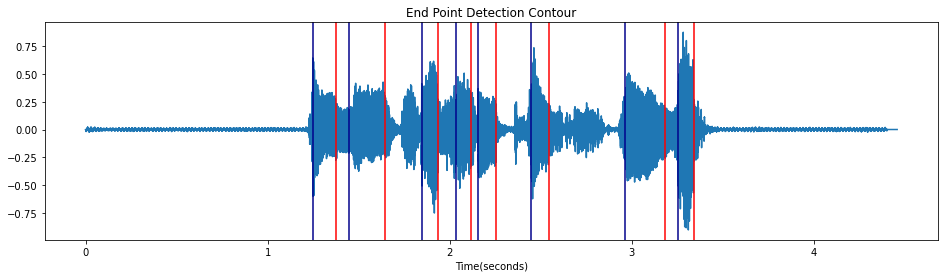

In [29]:
start_t, end_t = get_boundaries(st_energy, zcr, frame_shift, fs)

plt.figure(figsize=(16, 4))
time = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(time, wave, label='Waveform')

for st, en in zip(start_t, end_t):
    plt.axvline(x=st, color='darkblue') 
    plt.axvline(x=en, color='red')

plt.title("End Point Detection Contour")
plt.xlabel("Time(seconds)")
plt.show()

#### Pitch Contour

以瞬間頻率推測音高  
並利用卷積平滑化圖表曲線

In [30]:
def get_max(p_matrix, p_shape):
    max_pMatrix = []
    for i in range(0, p_shape[1]):
        max_pMatrix.append(np.max(p_matrix[:,i]))
    return max_pMatrix                          #獲得每一列的最大值

def smooth(x,window_len=11,window='hanning'):
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

In [31]:
frame_len = int(25 * fs /1000) # 25ms
frame_shift = int(10 * fs /1000) # 10ms
frames = librosa.util.frame(wave, frame_length=frame_len, hop_length=frame_shift)

pitches, magnitudes = librosa.core.piptrack(y=wave, sr=fs, hop_length=frame_shift, threshold=0.75) 
#用來估計wave中每個時間窗口的基頻(pitch)和對應的振幅(magnitude)
#piptrack()返回的值為二維陣列，(時間窗口,頻率)並分別存於pitches與magnitudes

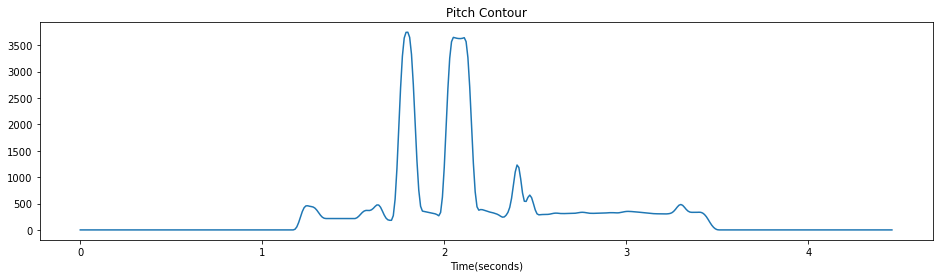

In [32]:
pitch_max = get_max(pitches, pitches.shape)
pitch_smooth = smooth(pitch_max, window_len=10)

time = np.linspace(0, len(wave)/fs, len(pitch_smooth))
plt.figure(figsize=(16, 4))
plt.plot(time,pitch_smooth,label='Pitch Contour')
plt.title("Pitch Contour")
plt.xlabel("Time(seconds)")
plt.show()

In [33]:
!jupyter nbconvert --to script main.ipynb

[NbConvertApp] Converting notebook main.ipynb to script
[NbConvertApp] Writing 5376 bytes to main.py
